In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=5117d8c8306d7132c4427e32b8c27eff8d6edfd888ec9f89fa33505ed0378508
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


100%|██████████| 708M/708M [00:59<00:00, 11.9MB/s]


Computed mean: 0.4680313169956207, std: 0.23491597175598145


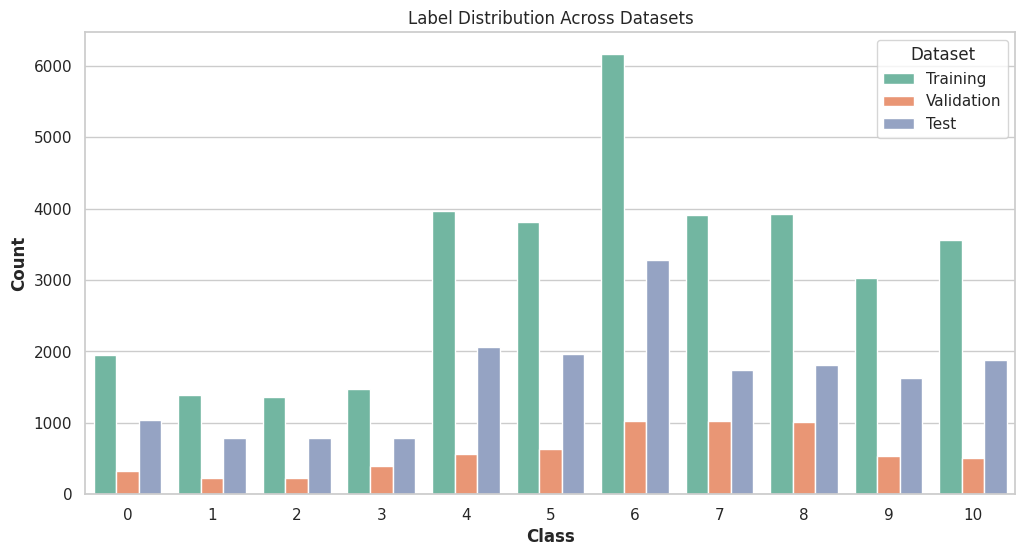

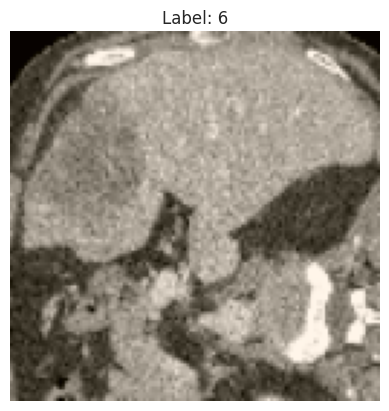

Image shape: torch.Size([3, 128, 128])
Using device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from medmnist import OrganAMNIST
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class AdjustLabelsDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        # Convert labels to tensor and remove extra dimensions
        y = torch.tensor(y).long().squeeze()
        return X, y

# images to tensors
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

#  Loading the dataset with transformation
train_dataset_raw = OrganAMNIST(split="train", download=True, transform=initial_transform,size=128)
val_dataset_raw = OrganAMNIST(split="val", transform=initial_transform,size=128)
test_dataset_raw = OrganAMNIST(split="test", transform=initial_transform,size=128)


#  DataLoader with batchsize=1 to iterate over individual images
train_loader_raw = DataLoader(train_dataset_raw, batch_size=1)

# Initialize variables to compute mean and std
mean_sum = 0.0
std_sum = 0.0
num_samples = len(train_dataset_raw)

for data, _ in train_loader_raw:
    data = data.float()
    mean_sum += data.mean()
    std_sum += data.std()

mean = mean_sum / num_samples
std = std_sum / num_samples

print(f"Computed mean: {mean.item()}, std: {std.item()}")

#  transformation with normalization
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])
])

# Re-load the datasets with the normalization
train_dataset = OrganAMNIST(split="train", transform=transform,size = 128)
val_dataset = OrganAMNIST(split="val", transform=transform,size =128)
test_dataset = OrganAMNIST(split="test", transform=transform,size = 128)


# Wrap the datasets with AdjustLabelsDataset
train_dataset = AdjustLabelsDataset(train_dataset)
val_dataset = AdjustLabelsDataset(val_dataset)
test_dataset = AdjustLabelsDataset(test_dataset)


################# for barplot
# Extract labels
train_labels = [label.item() for _, label in train_dataset]
val_labels = [label.item() for _, label in val_dataset]
test_labels = [label.item() for _, label in test_dataset]

# Count labels
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

num_classes = 11  # As defined in your model
classes = list(range(num_classes))

#  lists of counts
train_counts_list = [train_counts.get(cls, 0) for cls in classes]
val_counts_list = [val_counts.get(cls, 0) for cls in classes]
test_counts_list = [test_counts.get(cls, 0) for cls in classes]

# Create a DataFrame
data = {
    'Class': classes,
    'Training': train_counts_list,
    'Validation': val_counts_list,
    'Test': test_counts_list
}

df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Class', value_vars=['Training', 'Validation', 'Test'],
                    var_name='Dataset', value_name='Count')

sns.set(style="whitegrid")

# bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_melted, palette='Set2')

#  labels and title
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Label Distribution Across Datasets')

plt.legend(title='Dataset')

# Show the plot
plt.show()
##################

import matplotlib.pyplot as plt

# Fetch a sample from the training dataset
sample_image, sample_label = train_dataset[0]

# Convert tensor to NumPy array for visualization
image_np = sample_image.permute(1, 2, 0).numpy()
image_np = np.clip(image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

plt.imshow(image_np)
plt.title(f'Label: {sample_label}')
plt.axis('off')
plt.show()

print(f"Image shape: {sample_image.shape}")  # Expected: torch.Size([3, 128, 128])

# Define all possible classes (0 to 10)
all_classes = np.arange(11)

# Compute class weights using sklearn
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=all_classes,
    y=train_labels
)

# Convert class weights to a PyTorch tensor to move to device later
class_weights = torch.tensor(class_weights, dtype=torch.float)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create DataLoaders
batch_size = 64  # Adjust based on your GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,  # Adjust based on your CPU cores
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,  # Adjust based on your CPU cores
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,  # Adjust based on your CPU cores
    pin_memory=True
)

# Load the pretrained ResNet18 model
resnet = models.resnet18(pretrained=True)

# Modify the final fully connected layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 11)  # OrganAMNIST has 11 classes

# Freeze all layers except the final fully connected layer
for param in resnet.parameters():
    param.requires_grad = False

for param in resnet.fc.parameters():
    param.requires_grad = True

# Move the model to the appropriate device
resnet.to(device)


Epoch [1/20], Train Loss: 0.5710, Train Accuracy: 84.31%, Val Loss: 0.2329, Val Accuracy: 93.44%
Epoch [2/20], Train Loss: 0.3000, Train Accuracy: 90.56%, Val Loss: 0.1976, Val Accuracy: 93.50%
Epoch [3/20], Train Loss: 0.2542, Train Accuracy: 91.66%, Val Loss: 0.1836, Val Accuracy: 93.39%
Epoch [4/20], Train Loss: 0.2381, Train Accuracy: 91.95%, Val Loss: 0.1690, Val Accuracy: 93.96%
Epoch [5/20], Train Loss: 0.2198, Train Accuracy: 92.41%, Val Loss: 0.1637, Val Accuracy: 94.45%
Epoch [6/20], Train Loss: 0.2160, Train Accuracy: 92.56%, Val Loss: 0.1752, Val Accuracy: 93.70%
Epoch [7/20], Train Loss: 0.2066, Train Accuracy: 92.75%, Val Loss: 0.1677, Val Accuracy: 94.16%
Epoch [8/20], Train Loss: 0.1982, Train Accuracy: 93.10%, Val Loss: 0.1551, Val Accuracy: 94.30%
Epoch [9/20], Train Loss: 0.1959, Train Accuracy: 93.24%, Val Loss: 0.1888, Val Accuracy: 93.70%
Epoch [10/20], Train Loss: 0.1890, Train Accuracy: 93.36%, Val Loss: 0.1791, Val Accuracy: 93.91%
Epoch [11/20], Train Loss: 0.

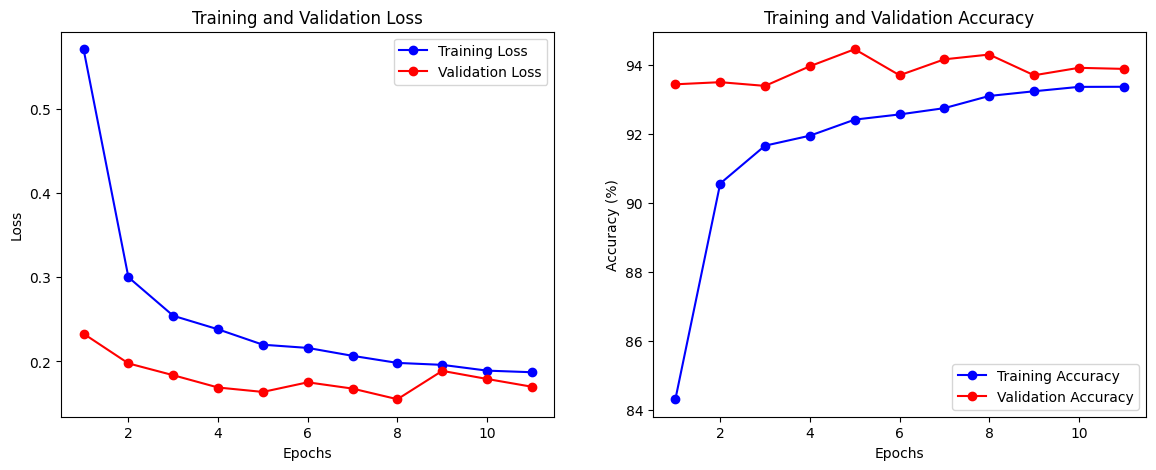

In [17]:
# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define the optimizer (only parameters that require gradients)
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

# Number of epochs
num_epochs = 20  # Adjust based on your requirements

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early Stopping Parameters
best_val_loss = float('inf')
patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    ###################
    # Training Phase
    ###################
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    ####################
    # Validation Phase
    ####################
    resnet.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = resnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train Accuracy: {epoch_train_accuracy:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, '
          f'Val Accuracy: {epoch_val_accuracy:.2f}%')

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(resnet.state_dict(), 'best_resnet.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

# Plot Training and Validation Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [18]:
# Load the best model
resnet.load_state_dict(torch.load('best_resnet.pth'))
resnet.eval()

# Load test dataset
test_dataset = OrganAMNIST(split='test', transform=transform, size=128)
test_dataset = AdjustLabelsDataset(test_dataset)



# Initialize variables for test metrics
test_running_loss = 0.0
test_correct = 0
test_total = 0


with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        test_outputs = resnet(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        test_running_loss += test_loss.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_epoch_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%')


<ipython-input-18-bfb3fc873aa2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load('best_resnet.pth'))


Test Loss: 0.3745, Test Accuracy: 88.00%


In [19]:
from sklearn.metrics import classification_report

# Collect all true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        test_outputs = resnet(test_inputs)
        _, test_predicted = torch.max(test_outputs.data, 1)

        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.6664    0.8678    0.7539      1036
           1     0.8819    0.8189    0.8492       784
           2     0.8566    0.8436    0.8501       793
           3     0.9854    0.8599    0.9184       785
           4     0.6880    0.7747    0.7288      2064
           5     0.8670    0.6438    0.7389      1965
           6     0.9875    0.9890    0.9883      3285
           7     0.9830    0.9954    0.9892      1747
           8     0.9759    0.9812    0.9785      1813
           9     0.8871    0.9593    0.9218      1622
          10     0.8662    0.8349    0.8503      1884

    accuracy                         0.8800     17778
   macro avg     0.8768    0.8699    0.8698     17778
weighted avg     0.8865    0.8800    0.8800     17778

